In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics

import dask
import timeit

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
## Define metrics

In [3]:
def _BSS(mod=None, obs=None):
    return ((mod-obs)**2)
#     print('Warning: not squaring, using abs')

def BrierSkillScore(da_mod_sip=None, 
                    da_obs_ip=None, 
                    testplots=False,
                   region=None):
    '''
    Brier Skill Score
    ----------
    Parameters:
    da_mod_sip : DataArray
        DataArray of modeled sea ice probabilies (0-1)
    da_obs_ip : DataArray
        DataArray of observed sea ice presence (0 or 1)
    time_dim: String
        Name of time dimension to take mean over when calculating the BSS
    region : DataSet
        DataSet contain spatial location of Arctic regions
    testplots : Boolean
        Flag to turn on test plots    
        
    Returns:
    BSS = Brier Skill Score
    '''
    
    # Should already be formated the same
    assert (sorted(da_mod_sip.dims) == sorted(da_obs_ip.dims)), "Dims should be the same."
    
    # spatial dims in model and obs should be 'x' and 'y' to match regions var names
    assert ('x' in da_mod_sip.dims), "'x' and 'y' should be dims."
    assert ('y' in da_obs_ip.dims), "'x' and 'y' should be dims"
        
#     # Mask to regions of Arctic we are interested in
    da_mod_sip = da_mod_sip.where(region.mask.isin(region.ocean_regions))
    da_obs_ip = da_obs_ip.where(region.mask.isin(region.ocean_regions))
        
    # Calculate Brier Skill Score
    BSS = _BSS(mod = da_mod_sip, 
               obs = da_obs_ip)
    
    if testplots:
        plt.figure()
        da_mod_sip.plot()
        
        plt.figure()
        da_obs_ip.plot() 
        
        plt.figure()
        BSS.plot()
            
    return BSS

In [4]:
def IIEE(da_mod=None, da_obs=None, region=None, sic_threshold=0.15, testplots=False):
    ''' The Integrated Ice‐Edge Error Goessling 2016'''
    
    # Input
    # da_mod/da_obs - DataArray of sic from model/observations
    
    # Output
    # IEEE - Area of IEEE in millions of km^2, 
    
    # Should already be formated the same
    assert (sorted(da_mod.dims) == sorted(da_obs.dims)), "Dims should be the same."
    
    # spatial dims in model and obs should be 'x' and 'y' to match regions var names
    assert ('x' in da_mod.dims), "'x' and 'y' should be dims."
    assert ('y' in da_obs.dims), "'x' and 'y' should be dims."
    
    # Reduce to sea ice presence
    mod_sip = (da_mod >= sic_threshold).where(da_mod.notnull())
    obs_sip = (da_obs >= sic_threshold).where(da_obs.notnull())
    
    # Mask to regions of Arctic we are interested in
    mod_sip = mod_sip.where(region.mask.isin(region.ocean_regions))
    obs_sip = obs_sip.where(region.mask.isin(region.ocean_regions))
    
    if testplots:
        plt.figure()
        (abs(mod_sip - obs_sip)).plot()
    
    # Calculate both terms (over and under area) in millions of km^2
    IIEE = (abs(mod_sip - obs_sip) * region.area ).sum(dim=['x','y'])/(10**6)
#     print("MOdifeid mean instead of sum!")
    
    # Remove IIEE values of zero where model AND observation were missing
    have_mod_and_obs = (mod_sip.sum(['x','y']) > 0) & (obs_sip.sum(['x','y']) > 0) 
    IIEE = IIEE.where(have_mod_and_obs)
    
    return IIEE

### IIEE is LOWER if applied to individual ensembles then averaged

In [5]:
# Real data test
# Load from Zarr
E = ed.EsioData.load()
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))
ds_m = xr.open_zarr('/home/disk/sipn/nicway/data/model/zarr/sic.zarr')
ds_m

<xarray.Dataset>
Dimensions:    (fore_time: 52, init_end: 47, model: 20, x: 304, y: 448)
Coordinates:
  * fore_time  (fore_time) timedelta64[ns] 0 days 7 days ... 350 days 357 days
  * init_end   (init_end) datetime64[ns] 2018-01-07 2018-01-14 ... 2018-11-25
    lat        (x, y) float64 dask.array<shape=(304, 448), chunksize=(152, 224)>
    lon        (x, y) float64 dask.array<shape=(304, 448), chunksize=(152, 224)>
  * model      (model) object 'Observed' 'awispin' ... 'yopp' 'MME'
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
Data variables:
    SIP        (init_end, model, fore_time, y, x) float64 dask.array<shape=(47, 20, 52, 448, 304), chunksize=(1, 1, 1, 448, 304)>
    anomaly    (init_end, model, fore_time, y, x) float64 dask.array<shape=(47, 20, 52, 448, 304), chunksize=(1, 1, 1, 448, 304)>
    mean       (init_end, model, fore_time, y, x) float64 dask.array<shape=(4

In [6]:
ds_m.model

<xarray.DataArray 'model' (model: 20)>
array(['Observed', 'awispin', 'climatology', 'dampedAnomalyTrend', 'ecmwf',
       'ecmwfsipn', 'gfdlsipn', 'kma', 'metreofr', 'ncep', 'nicosipn',
       'rasmesrl', 'szapirosipn', 'ukmetofficesipn', 'ukmo', 'usnavygofs',
       'usnavyncep', 'usnavysipn', 'yopp', 'MME'], dtype=object)
Coordinates:
  * model    (model) object 'Observed' 'awispin' 'climatology' ... 'yopp' 'MME'

In [7]:
it_selected = 20

### Try plottin spatial fields to see WHERE BS and IIEE (not summed) are different

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: Runtime

Text(0.5,1,'IIEE')

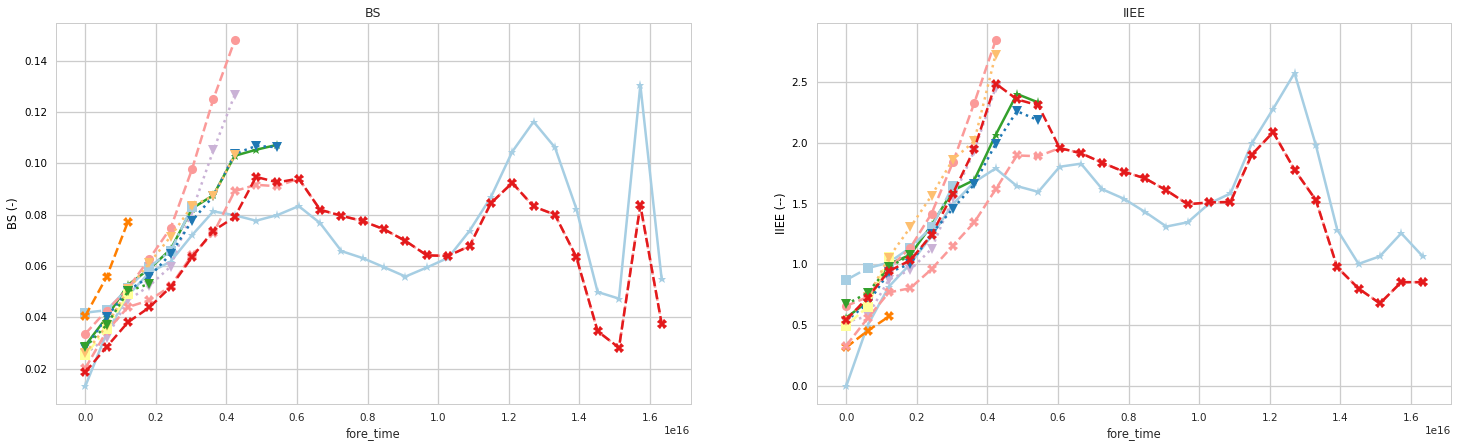

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(25,7))


for cmod in ds_m.model.values:
    
    if (cmod=='Observed') | (cmod=='climatology'):
        continue

    # Get one model
    mod_C = ds_m.sel(model=cmod).isel(init_end=it_selected)
    obs_C = ds_m.sel(model='Observed').isel(init_end=it_selected)

    # BS
    cBS = BrierSkillScore(da_mod_sip= mod_C.SIP, 
                    da_obs_ip=obs_C.SIP, 
                    region=ds_region,      
                    testplots=False)
    # print("BS is",cBS.values)

    # IIEE (take mean of ensemble SIC first, then threshold, then difference)
    cIIEE = IIEE(da_mod=mod_C['mean'], da_obs=obs_C['mean'], region=ds_region, sic_threshold=0.15, testplots=False)
    # print("IIEE is",cIIEE.values)

    # # IIEE (IIEE first of each ensemble, than average)
    # cIIEE_indiv = IIEE(da_mod=cda, da_obs=obs_ens, sic_threshold=0.15, testplots=False)
    # print("IIEE individual is",cIIEE_indiv.values)
    # print("IIEE individual mean is",cIIEE_indiv.mean().values)
    # print("")

    cBS.mean(dim=['x','y']).plot(ax=axes[0],color=E.model_color[cmod],label='BS', linestyle=E.model_linestyle[cmod], marker=E.model_marker[cmod]);
    
    cIIEE.plot(ax=axes[1],color=E.model_color[cmod],label='IIEE', linestyle=E.model_linestyle[cmod], marker=E.model_marker[cmod]);

    
axes[0].set_ylabel('exp', color='k')
axes[0].tick_params(axis='y', labelcolor='k')
axes[0].set_ylabel('BS (-)')
axes[0].set_title('BS')

axes[1].set_ylabel('sin', color='k')  # we already handled the x-label with ax1
axes[1].tick_params(axis='y', labelcolor='k')
axes[1].set_ylabel('IIEE (--)')
axes[1].set_title('IIEE')

In [14]:
ds_m.model

<xarray.DataArray 'model' (model: 20)>
array(['Observed', 'awispin', 'climatology', 'dampedAnomalyTrend', 'ecmwf',
       'ecmwfsipn', 'gfdlsipn', 'kma', 'metreofr', 'ncep', 'nicosipn',
       'rasmesrl', 'szapirosipn', 'ukmetofficesipn', 'ukmo', 'usnavygofs',
       'usnavyncep', 'usnavysipn', 'yopp', 'MME'], dtype=object)
Coordinates:
  * model    (model) object 'Observed' 'awispin' 'climatology' ... 'yopp' 'MME'

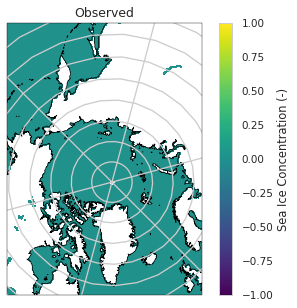

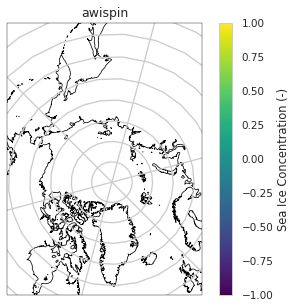

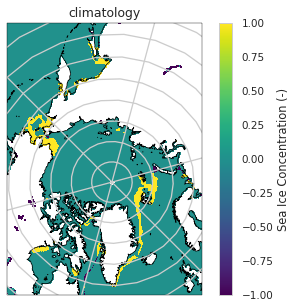

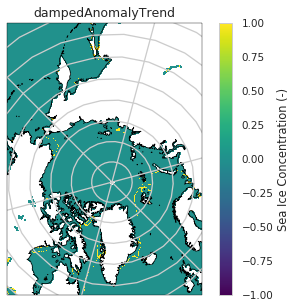

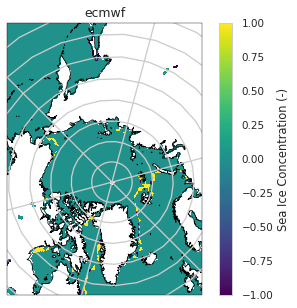

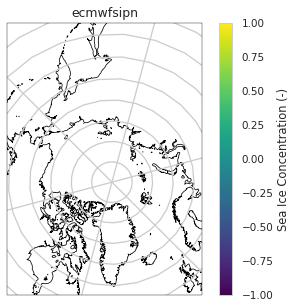

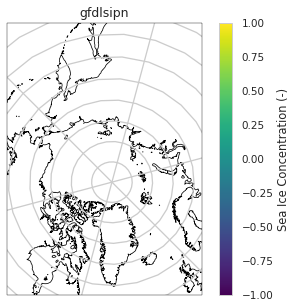

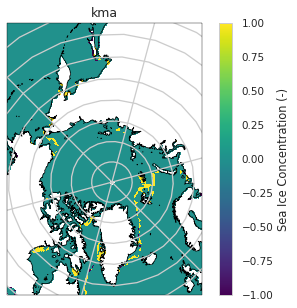

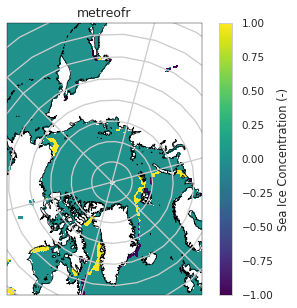

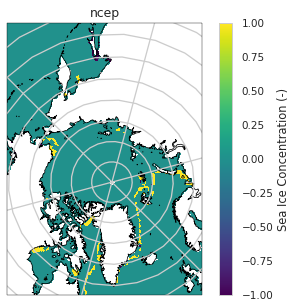

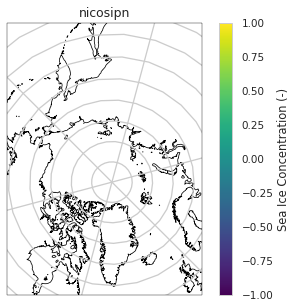

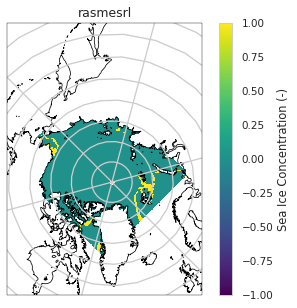

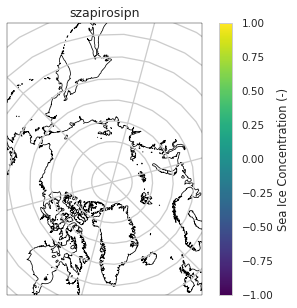

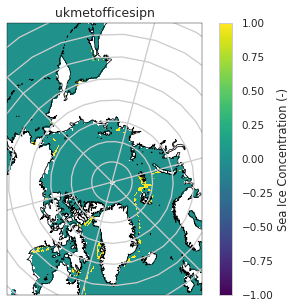

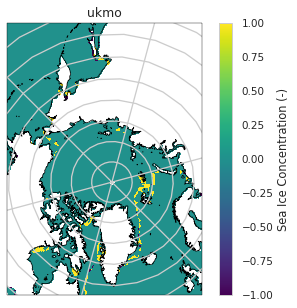

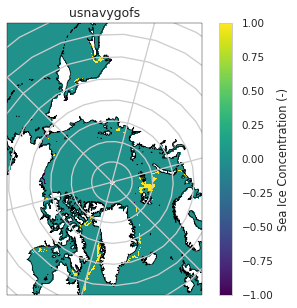

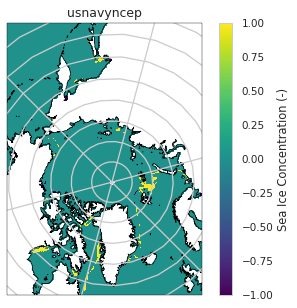

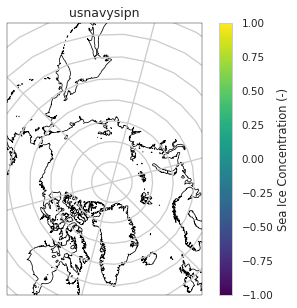

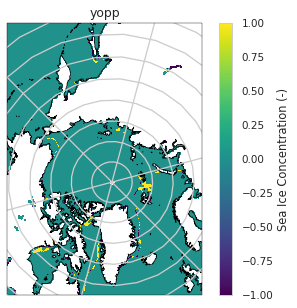

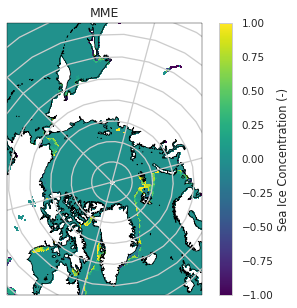

In [13]:
for cmod in ds_m.model.values:
    (f, ax) = ice_plot.polar_axis()
    (ds_m.sel(model=cmod).isel(init_end=it_selected,fore_time=0)['SIP']-ds_m.sel(model='Observed').isel(init_end=it_selected,fore_time=0)['SIP']).plot(ax=ax, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                      vmin=-1, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
    ax.set_title(cmod)

Text(0.5,0,'SIP')

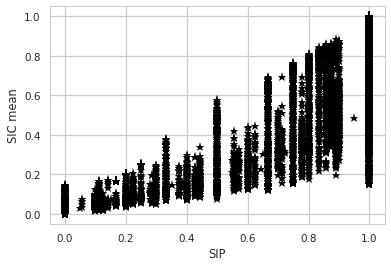

In [10]:
plt.figure()
plt.plot(mod_C.isel(fore_time=0)['SIP'], mod_C.isel(fore_time=0)['mean'],'k*');
plt.ylabel('SIC mean')
plt.xlabel('SIP')


In [11]:
# # Make some Idealized ice
# obs = xr.DataArray(np.zeros((10, 10)),dims=('x','y'),coords={'x':np.arange(0,10),'y':np.arange(0,10),})
# obs[3:6,3:6] = 1
# obs.plot()



# # Make an Over prediction
# OverP = xr.DataArray(np.zeros((10, 10)),dims=('x','y'),coords={'x':np.arange(0,10),'y':np.arange(0,10),})
# OverP[2:7,2:7] = 1
# OverP.plot()
# OverP.sum().values

# # Make an Under prediction
# UnderP = xr.DataArray(np.zeros((10, 10)),dims=('x','y'),coords={'x':np.arange(0,10),'y':np.arange(0,10),})
# UnderP[4,4] = 1
# UnderP.plot()

# # All Miss
# allMiss = xr.DataArray(np.zeros((10, 10)),dims=('x','y'),coords={'x':np.arange(0,10),'y':np.arange(0,10),})
# allMiss[0:3,0:3] = 1
# allMiss.plot()

# # Offcenter
# offCen = xr.DataArray(np.zeros((10, 10)),dims=('x','y'),coords={'x':np.arange(0,10),'y':np.arange(0,10),})
# offCen[2:5,2:5] = 1
# offCen.plot()



# Ne = 10 # Number of ensembles

# # copy obs for each model ensemble
# l = []
# for e in np.arange(0,Ne):
#     da1 = obs.copy()
#     da1['ensemble'] = e
#     l.append(da1)
# obs_ens = xr.concat(l, dim='ensemble')

# # Make a model with perfect values for all ensembles
# l = []
# for e in np.arange(0,Ne):
#     da1 = obs.copy()
#     da1['ensemble'] = e
#     l.append(da1)
# mod_Pm_Ps = xr.concat(l, dim='ensemble')

# # Make a model with all bad values
# l = []
# for e in np.arange(0,Ne):
#     da1 = allMiss.copy()
#     da1['ensemble'] = e
#     l.append(da1)
# mod_allMiss = xr.concat(l, dim='ensemble')

# # Make a model with shifted location
# l = []
# for e in np.arange(0,Ne):
#     da1 = offCen.copy()
#     da1['ensemble'] = e
#     l.append(da1)
# mod_offCen = xr.concat(l, dim='ensemble')

# # Make a model with perfect mean but large spread
# l = []
# for e in np.arange(0,5):
#     da1 = UnderP.copy()
#     da1['ensemble'] = e
#     l.append(da1)
# for e in np.arange(5,Ne):
#     da1 = OverP.copy()
#     da1['ensemble'] = e
#     l.append(da1)
# mod_Pm_Bs = xr.concat(l, dim='ensemble')



# # Linear Ocean










# all_models = {'Perfect Mean and Varience':mod_Pm_Ps,
#              'Perfect mean but Large Varience':mod_Pm_Bs,
#              'mod_allMiss':mod_allMiss,
#              'mod_offCen':mod_offCen}

# sic_thres=0.15



# ### What is the Correct way to implement the IIEE?

# ### Why are the model rankings different using the BS or the IIEE?

# # Calculate all metrics
# for (cmodName) in all_models:
#     print(cmodName)
#     cda = all_models[cmodName]
    
#     # BS
#     cBS = BrierSkillScore(da_mod_sip= (cda>=sic_thres).mean(dim='ensemble'), 
#                     da_obs_ip=obs, 
#                     testplots=False)
#     print("BS is",cBS.mean().values)
    
#     # IIEE (take mean of ensemble SIC first, then threshold, then difference)
#     cIIEE = IIEE(da_mod=cda.mean(dim='ensemble'), da_obs=obs_ens.mean(dim='ensemble'), sic_threshold=0.15, testplots=False)
#     print("IIEE is",cIIEE.values)
    
#     # IIEE (IIEE first of each ensemble, than average)
#     cIIEE_indiv = IIEE(da_mod=cda, da_obs=obs_ens, sic_threshold=0.15, testplots=False)
#     print("IIEE individual is",cIIEE_indiv.values)
#     print("IIEE individual mean is",cIIEE_indiv.mean().values)
#     print("")
    
#     plt.figure()
#     cda.mean(dim='ensemble').plot()
#     plt.title(cmodName)